In [12]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance


# permutation feature importance and feature importance based on MSE gives simular results but
# permutation method is good for numerical features


In [2]:
# Importing the data stored as pickle file

data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/abc_regression_modelling.p', "rb"))
#rb = reading a file rather than writing 'wb' as writing as a file.


In [3]:
data_for_model.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [4]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 869
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             400 non-null    int64  
 1   distance_from_store     398 non-null    float64
 2   gender                  397 non-null    object 
 3   credit_score            398 non-null    float64
 4   customer_loyalty_score  400 non-null    float64
 5   total_sales             400 non-null    float64
 6   total_items             400 non-null    int64  
 7   transaction_count       400 non-null    int64  
 8   product_area_count      400 non-null    int64  
 9   average_basket_value    400 non-null    float64
dtypes: float64(5), int64(4), object(1)
memory usage: 34.4+ KB


In [5]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [6]:
data_for_model.shape

(400, 9)

In [7]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [8]:
data_for_model.head(5)

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


In [9]:
data_for_model.dropna(how='any', inplace=True)

In [10]:
data_for_model.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [11]:
# In random forest just like decision tree, no need to remove outliers
# decision tree make split decisions based on the data either side of a line
# they don't really care how far away a point is interms of the distance
# so removing outliers won't change anything at all



In [13]:
# splitting input & output variable

X = data_for_model.drop('customer_loyalty_score',axis=1)
y = data_for_model['customer_loyalty_score']

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(315, 8)
(79, 8)
(315,)
(79,)


In [16]:
# decision tree still need data to be in numeric form

# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first ( this is not so important in
# decision trees & random forest, it would'nt have added anything, so its best to remove them from the mix)

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)

In [18]:
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [17]:
# no need feature selection in decision tree


# in decision tree each variable is judged independently
# so if there is'nt any predictive power within an input variable , it will essentially be just be ignored anyway
# in saying this, even though it is not strictly required , it is'nt necessarly a bad thing to do feature selection
# and thus remove some features
# if you are in a situation that have high number of input variables, reducing this to a subset that are strongly linked to
# the output or target variable will mean much less computation is required
# training & prediction must be quicker
# to summarize applying feature selection won't make any difference to the performance of the decision tree
# in terms of accuracy, but it could help with performance in terms of computation
# since we are dealing with small number of input variables here we are going to remove this section of applying feature
# selection.

In [19]:
y_pred = regressor.predict(X_test)

In [20]:
r_squared = r2_score(y_test,y_pred)
print(r_squared)

0.959697583473264


In [21]:
cv = KFold(n_splits=4,shuffle=True,random_state=42)

cv_scores1 = cross_val_score(regressor,X_train,y_train,cv=cv,scoring="r2")

print(cv_scores1.mean())

0.9248320106571228


In [22]:
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1-r_squared)  * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(adjusted_r_squared)

0.9550915930130656


        input_variables  Feature_importance
7  average_basket_value            0.010009
1                gender            0.010709
6    product_area_count            0.021625
4           total_items            0.027484
5     transaction_count            0.040601
3           total_sales            0.097624
2          credit_score            0.112214
0   distance_from_store            0.679734


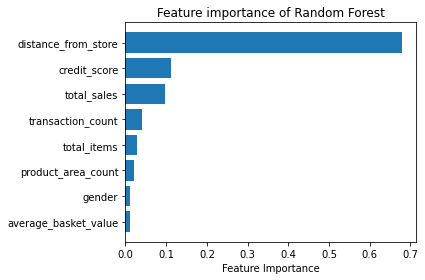

In [24]:
feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],axis=1)
feature_importance_summary.columns=['input_variables','Feature_importance']
feature_importance_summary.sort_values(by='Feature_importance',inplace=True)
print(feature_importance_summary)

plt.barh(feature_importance_summary['input_variables'],feature_importance_summary['Feature_importance'])
plt.title('Feature importance of Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [25]:
# Permutation Importance

# The permutation feature importance is seen as decrease in model performance/accuracy when a particular input
# variables are randomly shuffled
# randomly shuffled destroys any relationship would have with the output variable and thus
# gives us a way to understand its importance as we can compare model performance with the shuffling 
# and with the values in their normal state 

# A large decrease in model performance when shuffled would indicate this as an input variable
# with high level of importance to our predictions and this approach is often preferred
# over standard feature importance method that we used above that measures the improvement of mean squared error
# as this can sometimes inflate the importance of numerical features

# but both methods are useful and in most cases will give fairly similar results


result = permutation_importance(regressor,X_test,y_test,n_repeats=10, random_state=42)
# n_repeat = specifies how many times we have to apply this random shuffling to each variable
print(result)

{'importances_mean': array([1.45410236e+00, 1.12212257e-03, 1.17425577e-01, 1.28328232e-01,
       1.81334830e-02, 4.34815963e-02, 8.09052482e-03, 4.23971620e-03]), 'importances_std': array([0.18027374, 0.00123563, 0.02137461, 0.00971102, 0.00414825,
       0.009169  , 0.00310793, 0.00152432]), 'importances': array([[ 1.35326657e+00,  1.32946448e+00,  1.23316338e+00,
         1.14976811e+00,  1.67114274e+00,  1.49898361e+00,
         1.70304098e+00,  1.49305468e+00,  1.44264431e+00,
         1.66649473e+00],
       [ 1.23820016e-03,  1.31312209e-03,  2.92815408e-04,
         1.49150299e-03,  4.67705964e-04,  3.69793146e-03,
        -1.42417340e-03,  1.70727165e-03,  1.71142756e-03,
         7.25421797e-04],
       [ 1.01333336e-01,  1.26675680e-01,  1.64790728e-01,
         1.18411618e-01,  1.29986041e-01,  1.02399148e-01,
         8.18453853e-02,  1.06454306e-01,  1.11647750e-01,
         1.30711783e-01],
       [ 1.16237318e-01,  1.39521397e-01,  1.28632124e-01,
         1.24434932e-

        input_variables  permutation_importance
1                gender                0.001122
7  average_basket_value                0.004240
6    product_area_count                0.008091
4           total_items                0.018133
5     transaction_count                0.043482
2          credit_score                0.117426
3           total_sales                0.128328
0   distance_from_store                1.454102


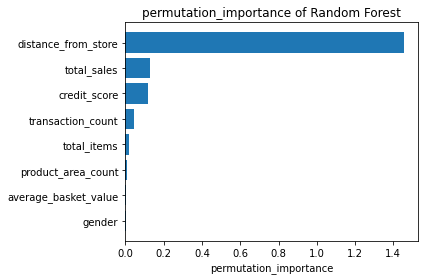

In [26]:
permutation_importance = pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],axis=1)
permutation_importance_summary.columns=['input_variables','permutation_importance']
permutation_importance_summary.sort_values(by='permutation_importance',inplace=True)
print(permutation_importance_summary)

plt.barh(permutation_importance_summary['input_variables'],permutation_importance_summary['permutation_importance'])
plt.title('permutation_importance of Random Forest')
plt.xlabel('permutation_importance')
plt.tight_layout()
plt.show()

In [27]:
# the differences are not major, there are couple of swaps of position i.e credit_score & total_sales are swapped
# its kind of interesting that distance from store in this approach is proportionally more important than it did
# in the first approach

# as i said both are methods are useful , the results are fairly similar
# what we are really after is way to understand what is driving the predictions in our model, 
# i think both ways offer up pretty similar narrative

# in general permutation approach is slightly superior approach , if you want to go with one of 
# approaches, then permutation you can choose

# Just remember to explain exactly how it works to the stakeholders so they understand it and they
# will be comfortable moving forward.


In [31]:
# predictions under the hood

print(y_pred[0])
new_data = [X_test.iloc[0]]
print(new_data)


0.22430000000000014
[distance_from_store        2.270000
credit_score               0.490000
total_sales             1506.490000
total_items              281.000000
transaction_count         47.000000
product_area_count         3.000000
average_basket_value      32.052979
gender_M                   0.000000
Name: 0, dtype: float64]


In [30]:
regressor.estimators_ ( these are the decision trees present under the hood of random forest)

[DecisionTreeRegressor(max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(max_features='auto', random_state=1935803228),
 DecisionTreeRegressor(max_features='auto', random_state=787846414),
 DecisionTreeRegressor(max_features='auto', random_state=996406378),
 DecisionTreeRegressor(max_features='auto', random_state=1201263687),
 DecisionTreeRegressor(max_features='auto', random_state=423734972),
 DecisionTreeRegressor(max_features='auto', random_state=415968276),
 DecisionTreeRegressor(max_features='auto', random_state=670094950),
 DecisionTreeRegressor(max_features='auto', random_state=1914837113),
 DecisionTreeRegressor(max_features='auto', random_state=669991378),
 DecisionTreeRegressor(max_features='auto', random_state=429389014),
 DecisionTreeRegressor(max_features='auto', random_state=249467210),
 DecisionTreeRegressor(max_features='auto', random_state=1972458954),
 DecisionTreeRegressor(max_f

In [35]:
predictions = []
tree_count = 0
for tree in regressor.estimators_:
    prediction=tree.predict(new_data)[0]
    predictions.append(prediction)
    tree_count+=1

print(predictions) # shows 100 predictions for this customer from each decision tree of random forest

print(sum(predictions)/len(predictions)) # we see its exactly same

[0.201, 0.668, 0.117, 0.17, 0.17, 0.268, 0.17, 0.203, 0.23400000000000004, 0.17, 0.234, 0.12, 0.234, 0.174, 0.147, 0.352, 0.268, 0.234, 0.234, 0.234, 0.203, 0.17400000000000002, 0.12, 0.234, 0.177, 0.12, 0.314, 0.174, 0.234, 0.302, 0.352, 0.314, 0.234, 0.174, 0.116, 0.221, 0.147, 0.177, 0.203, 0.147, 0.12, 0.234, 0.234, 0.201, 0.177, 0.221, 0.203, 0.366, 0.17, 0.334, 0.366, 0.17, 0.448, 0.12, 0.234, 0.136, 0.23400000000000004, 0.17, 0.174, 0.201, 0.147, 0.201, 0.366, 0.344, 0.221, 0.17400000000000002, 0.234, 0.117, 0.177, 0.12, 0.42, 0.344, 0.12, 0.221, 0.17, 0.234, 0.17, 0.203, 0.234, 0.234, 0.314, 0.234, 0.234, 0.143, 0.17, 0.234, 0.201, 0.12, 0.174, 0.201, 0.35200000000000004, 0.234, 0.174, 0.506, 0.177, 0.352, 0.352, 0.147, 0.234, 0.174]
0.22430000000000014


In [33]:
print(y_pred[0])

0.22430000000000014


In [37]:
import pickle

pickle.dump(regressor,open("/Users/praju/Desktop/DSI/Untitled Folder/random_forest_regression_model.p",'wb'))
pickle.dump(one_hot_encoder,open("/Users/praju/Desktop/DSI/Untitled Folder/random_forest_regression_ohe.p",'wb'))